# Correlating counts of signficant bases in exons

This notebook examines the spearmans correlations between the counts of signficant bases in exons between samples. It will produce figure 3c and figure S3b. 

In [36]:
import CGAT.Database as DB
import CGAT.IOTools as IOTools
import os
import re
import pandas as pd
import numpy as np
% load_ext rpy2.ipython
%R library(ggplot)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


The data is stored in a single table read for use. The following uses only the significant bases - as used inthe original paper

In [37]:
sig_bases = DB.fetch_DataFrame("SELECT * FROM sig_exon_counts",
                              "csvdb")

We are going to group the samples by the factor (Protein) they are addressing and then calculate the correlations between each sample and all other samples in the group - these will then be averaged for each sample. 

In order to do this, we first need to extract the factor from the sample name:

In [38]:
sig_bases["factor"] = sig_bases["track"].str.extract("(.+)-.+-.+")
sig_bases.head()

,count,method,name,track,factor
0,57,adjacency,ENSMUSG00000065629_986,Control-GFP-R1,Control
1,12,adjacency,ENSMUSG00000089512_1727,Control-GFP-R1,Control
2,189,adjacency,ENSMUSG00000075752_2242,Control-GFP-R1,Control
3,636,adjacency,ENSMUSG00000093247_2243,Control-GFP-R1,Control
4,587,adjacency,ENSMUSG00000093111_2244,Control-GFP-R1,Control


The `average_within_corr` function calculates the all pairwise correlations between samples in the provided `df` to produce a correlation matrix. It then does column means, excluding the self-self comparisons. 

An important note is that for each sample, an exon with 0 significant bases in it was not recorded. Here the pivot operation will mean that an entry for that exon will be added if it had significant bases in other samples. These are filled with 0. However, note that if there are no significant bases in any of the samples, this will lead to the exon being excluded from the analysis. This mirrors the analysis proceedure in the original paper. 

In [39]:
def average_within_corr(df):
    d = df.loc[~df.track.str.contains("agg")]
    p = d.pivot(index="name", columns="track", values="count").fillna(0)
    c = p.corr(method="spearman")
    c = c.apply(lambda x: x.drop(x.name).mean())
    c.name = "within"
    return c
        
    
within_factor = sig_bases.groupby(["method","factor"]).apply(average_within_corr)
within_factor = within_factor.reset_index()
within_factor["method"] = within_factor["method"].str.capitalize()
within_factor["Replicate"] = within_factor["track"].str.extract("(R[0-9]+)")
within_factor.head()

,method,factor,track,within,Replicate
0,Adjacency,Control,Control-GFP-R1,0.473015,R1
1,Adjacency,Control,Control-GFP-R2,0.340305,R2
2,Adjacency,Control,Control-GFP-R3,0.428278,R3
3,Adjacency,Control,Control-GFP-R4,0.267205,R4
4,Adjacency,Nxf1,Nxf1-GFP-R1,0.757028,R1


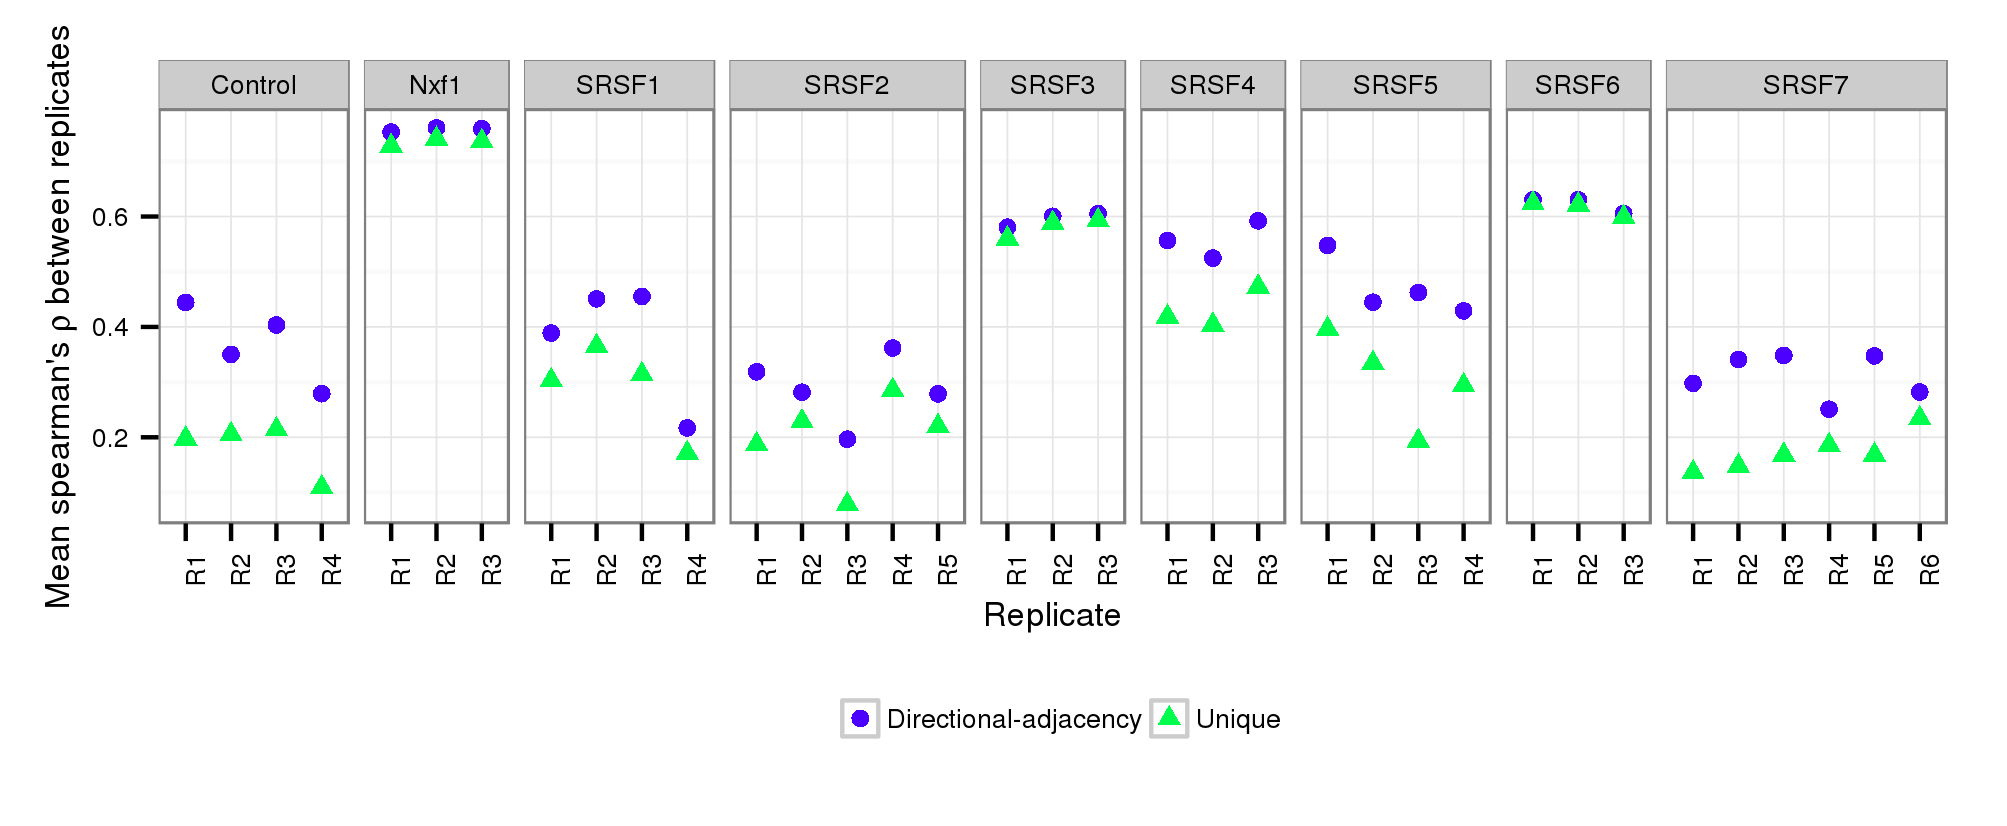

In [44]:
%%R -i within_factor -w 170 -h 70 -u mm -r 300
library(ggplot2)
library(Hmisc)
within_factor <- subset(within_factor, method %in% c("Directional","Unique"))
g <- ggplot(within_factor) + aes(x=Replicate, y=within,  color=method, shape=method) +
    geom_point(position="dodge", stat="identity", size=2) +
    theme_bw(base_size=8) + 
    facet_grid(~factor, space="free_x", scale="free_x") +
    ylab(expression(paste("Mean spearman's ",rho," between replicates"))) +
    scale_color_manual(name="", values=topo.colors(4)[c(1,3)]) +
    scale_shape_discrete(name="") +
    theme(axis.text.x=element_text(angle=90), 
          legend.position="bottom",
          legend.key.size=unit(0.6,"lines"))

print(g)
ggsave("plots/figure3c.svg", g)

To quantify the difference between the methods, we will look at the linear difference between the mean correlation for each method for each sample. We will plot that against the enrichment of bases with a mean edit distance of 1 distance between UMIs present compared to the null distribution as in figure 1. 

In [21]:
def get_null_enrichment(track):
    track=re.sub("-","_",track)
    return DB.fetch_DataFrame('''SELECT
                             (_unique+0.0)/_unique_null as enrichment
                               FROM %(track)s_dedup_cluster_edit_distance as ed
                               WHERE edit_distance =1 ''' % locals(), "csvdb").iloc[0][0]

within_factor["enrichment"] = within_factor["track"].apply(get_null_enrichment)

In [41]:
within_improvement = within_factor.pivot(index="track", columns="method", values="within")
within_improvement = within_improvement["Directional"] - within_improvement["Unique"]
within_improvement.name = "change"
within_improvement = within_improvement.reset_index()
within_improvement["enrichment"] = within_improvement["track"].apply(get_null_enrichment)



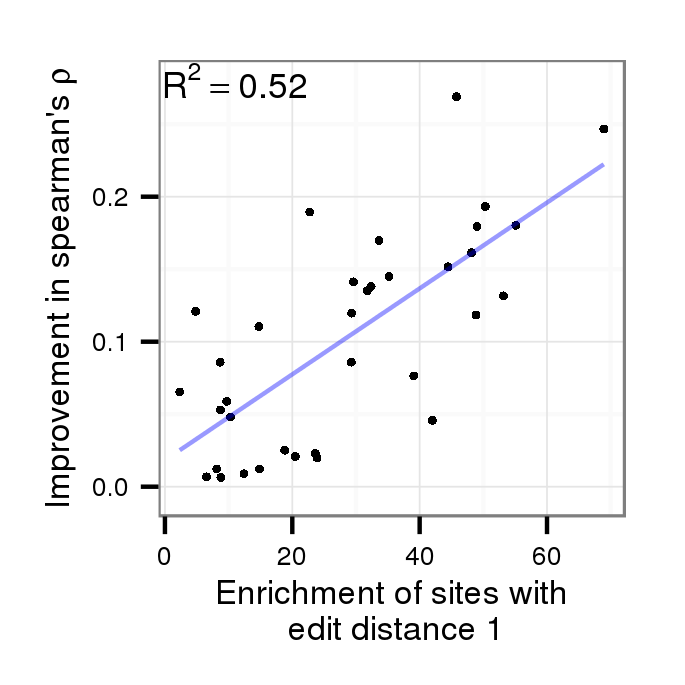

In [42]:
%%R -i within_improvement -w 58 -h 58 -u mm -r 300
rsquared = sprintf("%.03f",cor(within_improvement$change, within_improvement$enrichment)^2)
g <-ggplot(within_improvement) +
    aes(enrichment, change) +
    geom_point(size=1) + 
    geom_line(stat="smooth", method="lm", col="blue", alpha=0.4) +
    theme_bw(base_size=8) +
    xlab("Enrichment of sites with\n edit distance 1") +
    ylab(expression(paste("Improvement in spearman's",rho))) +
    annotate(label=paste("R^{2} == ",rsquared), parse=T, x=15, y=0.28, size=3, geom="text")
print(g)
ggsave("plots/figureS3b.svg", g)